<a href="https://colab.research.google.com/github/Ambika7783/Machine-learning/blob/main/Minorpro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

import joblib

In [3]:
df = pd.read_csv("/content/advertising.csv")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
print("Shape of dataset:", df.shape)
print("\nColumns:", list(df.columns))

df.info()
df.describe(include='all').transpose().head(20)

print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (1000, 10)

Columns: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory

In [7]:
numeric_features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
categorical_features = ['Male']
target_col = 'Clicked on Ad'

X = df[numeric_features + categorical_features]
y = df[target_col]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:
# Step 8: Preprocessing & Pipeline (fixed for latest scikit-learn)

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
]) if categorical_features else 'drop'

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        solver='liblinear', max_iter=1000, class_weight='balanced'))
])


In [11]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.98
Precision: 0.9897959183673469
Recall: 0.97
ROC-AUC: 0.9902

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [12]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best = grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'classifier__C': 10, 'classifier__penalty': 'l2'}


Final ROC-AUC: 0.9903
Final Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       100
           1       0.99      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



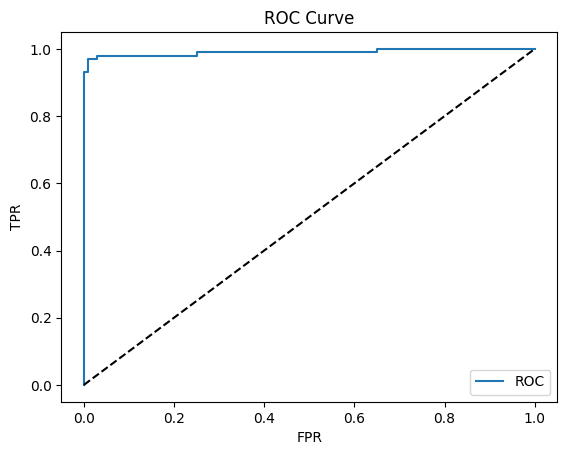

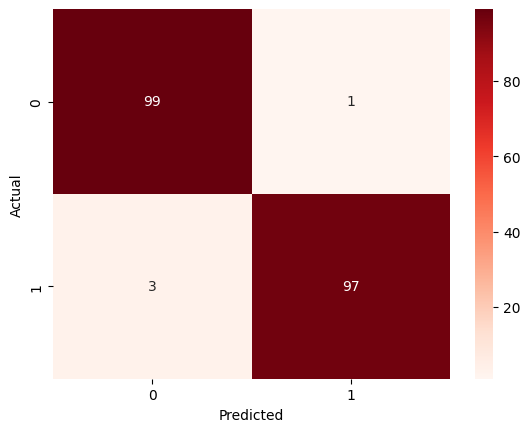

In [18]:
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)[:,1]

print("Final ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Final Report:\n", classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(); plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

In [14]:
num_out = numeric_features
cat_out = list(best.named_steps['preprocessor']
               .named_transformers_['cat']
               .named_steps['ohe']
               .get_feature_names_out(categorical_features)) if categorical_features else []
feature_names = num_out + cat_out

coeffs = best.named_steps['classifier'].coef_[0]
feat_imp = pd.Series(coeffs, index=feature_names).sort_values(key=abs, ascending=False)
print(feat_imp)

Daily Time Spent on Site   -3.236110
Daily Internet Usage       -2.605517
Area Income                -1.776209
Age                         1.439396
Male_0                      0.914304
Male_1                      0.292785
dtype: float64


In [15]:
joblib.dump(best, "ctr_logistic_pipeline.pkl")

['ctr_logistic_pipeline.pkl']

In [16]:
sample = X_test.iloc[[0]]
proba = best.predict_proba(sample)[:,1][0]
print("Predicted click probability:", proba)

Predicted click probability: 0.9999791884765431
